In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import ase
import ase.io as aio
import qml
import time
from sklearn.model_selection import train_test_split
import gc
gc.collect()
import sklearn.ensemble
import mlkrr 
import matplotlib as mpl

import os
import time
import pickle
%config Completer.use_jedi = False
%matplotlib notebook


In [2]:
reps = np.load('fchls_glob_qm9.npy', allow_pickle=True)

In [3]:
data = pd.read_csv('data_red.csv')

In [4]:
target = data.u0.values * 27.211399

In [5]:
target -= target.mean()

# target /= target.std()

In [6]:
np.mean(np.std(target))

1.0930130157747584

In [19]:
mlkr_model = np.load('trained_mlkr.npy', allow_pickle=True).item()
mlkrr_model = np.load('trained_mlkrr.npy', allow_pickle=True).item()

In [27]:
train_rmse = mlkrr_model.train_rmses
test_rmse = mlkrr_model.test_rmses

train_mae = mlkrr_model.train_maes
test_mae = mlkrr_model.test_maes

In [28]:
train_rmse_mlkr = mlkr_model.train_rmses
test_rmse_mlkr = mlkr_model.test_rmses

train_mae_mlkr = mlkr_model.train_maes
test_mae_mlkr = mlkr_model.test_maes

<IPython.core.display.Javascript object>


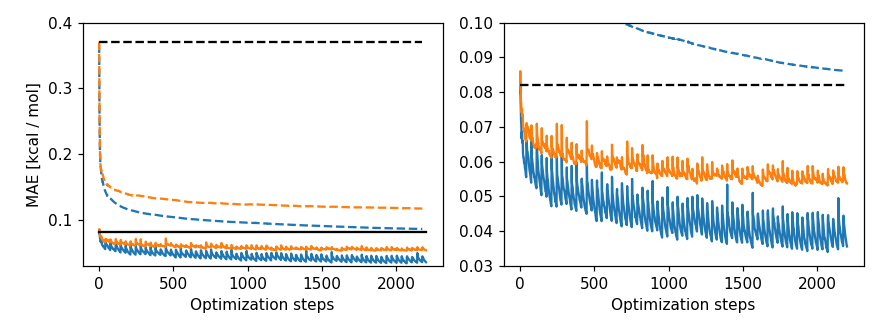

In [34]:
fig, axes = plt.subplots(figsize=[8,3], ncols=2)
ax = axes[0]

ax.plot([], label='MLKR', c='black', linestyle='--')
ax.plot(train_mae_mlkr, c='C0', linestyle='--')
ax.plot(test_mae_mlkr, label='Test MLKR', c='C1', linestyle='--')
ax.plot([0, len(train_rmse_mlkr)], [test_mae_mlkr[0], test_mae_mlkr[0]], 
        color='black', label='NW start', linestyle='--')


ax.plot(train_mae, label='Train MLKRR', c='C0', linestyle='-')
ax.plot(test_mae, label='Test MLKRR', c='C1', linestyle='-')
ax.plot([0, len(train_rmse)], [test_mae[0], test_mae[0]], color='black', label='KRR start', linestyle='-')

ax.set_xlabel('Optimization steps')
ax.set_ylabel('MAE [kcal / mol]')
# ax.legend(loc='upper right', framealpha=1)
ax.set_ylim(0.03, 0.4)

ax = axes[1]
ax.plot(train_mae_mlkr, c='C0', linestyle='--')

ax.plot(train_mae, label='Train MLKRR', c='C0', linestyle='-')
ax.plot(test_mae, label='Test MLKRR', c='C1', linestyle='-')
ax.plot([0, len(train_rmse)], [test_mae[0], test_mae[0]], color='black', label='KRR start', linestyle='--')
ax.set_xlabel('Optimization steps')
# ax.set_ylabel('MAE [kcal / mol]')
# ax.legend(loc='upper right', framealpha=1)
ax.set_ylim(0.03, 0.1)
plt.tight_layout()
plt.savefig('./optimizations.pdf')

plt.show()

In [35]:
reps_mlkrr = reps @ mlkrr_model.A.T

In [36]:
reps_mlkr = reps @ mlkr_model.A.T

In [37]:
train_size = 10000
test_size = 2000

In [38]:
indices_train, indices_test = sk.model_selection.train_test_split(
    np.arange(len(data)), train_size=train_size, test_size=test_size, random_state=0)

In [39]:
dmtrtr = sk.metrics.pairwise.pairwise_distances(reps[:,:][indices_train], n_jobs=-1)
dmtrts = sk.metrics.pairwise.pairwise_distances(
    reps[:,:][indices_test], reps[:,:][indices_train], n_jobs=-1)

In [40]:
dmtrtr_mlkr = sk.metrics.pairwise.pairwise_distances(reps_mlkr[:,:][indices_train], n_jobs=-1)
dmtrts_mlkr = sk.metrics.pairwise.pairwise_distances(
    reps_mlkr[:,:][indices_test], reps_mlkr[:,:][indices_train], n_jobs=-1)

In [41]:
dmtrtr_mlkrr = sk.metrics.pairwise.pairwise_distances(reps_mlkrr[:,:][indices_train], n_jobs=-1)
dmtrts_mlkrr = sk.metrics.pairwise.pairwise_distances(
    reps_mlkrr[:,:][indices_test], reps_mlkrr[:,:][indices_train], n_jobs=-1)

In [42]:
dmy1 = np.subtract.outer(target[indices_train], target[indices_train])

<IPython.core.display.Javascript object>


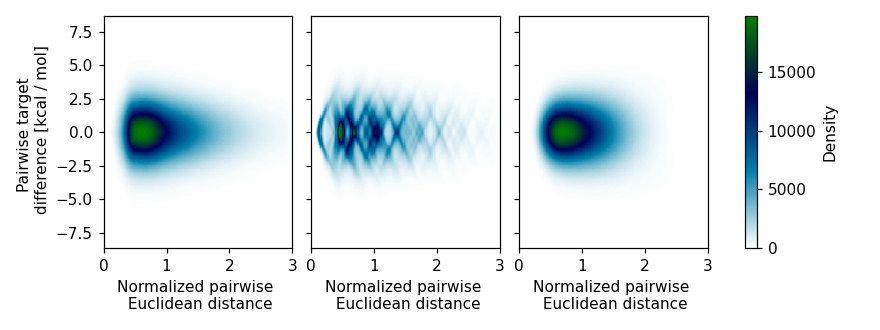

In [43]:
fig, axes = plt.subplots(ncols=3, figsize=[8,3], sharey=True)

ax = axes[0]
ax.hist2d(dmtrtr.ravel()[::1] / dmtrtr.mean(), dmy1.ravel()[::1], bins=300, 
#           range=[[0,3],[-10,10]], 
          cmap='ocean_r')

ax.set_xlabel('Normalized pairwise \n Euclidean distance')
ax.set_ylabel('Pairwise target \n difference [kcal / mol]')

ax.set_xlim(0, 3)
ax = axes[1]
cax = ax.hist2d(dmtrtr_mlkr.ravel()[::1] / dmtrtr_mlkr.mean(), dmy1.ravel()[::1], bins=300, 
#           range=[[0,3],[-10,10]],
          cmap='ocean_r')[-1]
ax.set_xlim(0, 3)
ax.set_xlabel('Normalized pairwise \n Euclidean distance')

ax = axes[2]
cax = ax.hist2d(dmtrtr_mlkrr.ravel()[::1] / dmtrtr_mlkrr.mean(), dmy1.ravel()[::1], bins=300, 
#           range=[[0,3],[-10,10]],
          cmap='ocean_r')[-1]
ax.set_xlabel('Normalized pairwise \n Euclidean distance')

ax.set_xlim(0, 3)
plt.tight_layout()
# ax.set_ylim(-5, 5)
# ax.set_yticks([-5,0,5])
plt.subplots_adjust(wspace=0.1, hspace=0)

cbar = fig.colorbar(cax, ax=axes.ravel().tolist())
cbar.set_label('Density')
plt.show()

# fig.savefig('diss_norm.png', dpi=300)

<IPython.core.display.Javascript object>


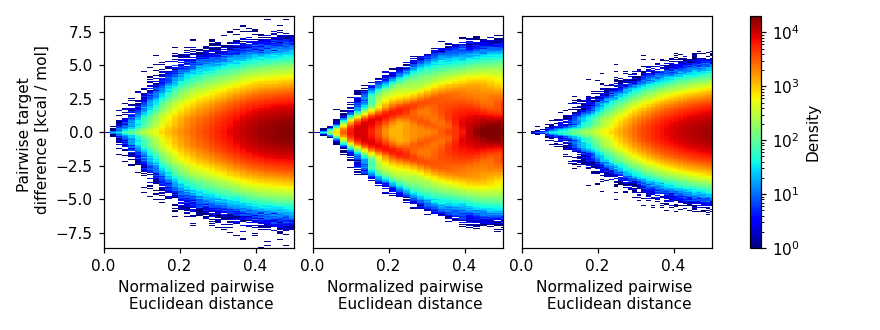

In [44]:
fig, axes = plt.subplots(ncols=3, figsize=[8,3], sharey=True)

ax = axes[0]
ax.hist2d(dmtrtr.ravel()[::1] / dmtrtr.mean(), dmy1.ravel()[::1], bins=300, 
#           range=[[0,3],[-10,10]], 
          norm=mpl.colors.LogNorm(),
          cmap='jet')

ax.set_xlabel('Normalized pairwise \n Euclidean distance')
ax.set_ylabel('Pairwise target \n difference [kcal / mol]')

ax.set_xlim(0, 0.5)
ax = axes[1]
cax = ax.hist2d(dmtrtr_mlkr.ravel()[::1] / dmtrtr_mlkr.mean(), dmy1.ravel()[::1], bins=300, 
#           range=[[0,3],[-10,10]],
          norm=mpl.colors.LogNorm(),
          cmap='jet')[3]
ax.set_xlim(0, 0.5)
ax.set_xlabel('Normalized pairwise \n Euclidean distance')

ax = axes[2]
cax = ax.hist2d(dmtrtr_mlkrr.ravel()[::1] / dmtrtr_mlkrr.mean(), dmy1.ravel()[::1], bins=300, 
#           range=[[0,3],[-10,10]],
          norm=mpl.colors.LogNorm(),
          cmap='jet')[3]
ax.set_xlim(0, 0.5)
ax.set_xlabel('Normalized pairwise \n Euclidean distance')
plt.tight_layout()

# ax.set_ylim(-5, 5)
# ax.set_yticks([-5,0,5])

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(cax, cax=cbar_ax)
plt.subplots_adjust(wspace=0.1, hspace=0)

cbar = fig.colorbar(cax, ax=axes.ravel().tolist())
cbar.set_label('Density')

# plt.tight_layout()
# plt.show()


# fig.savefig('diss_log.png', dpi=300)

# LC original

In [45]:
# KRR training with original data

# Training a KRR model involves optimizing the hyperparameter sigma
params = np.linspace(10,100, 5)

predictions_test = []
scores_test = []

regg = 1e-9

maes = []
rmses = []

for param in params:
    sigma=param
    
    kernel_constant = 1 / (1 * np.sqrt(2 * np.pi) * sigma)
    exponent_constant = 1 / (1 * sigma ** 2)
        
    K = kernel_constant * np.exp(
            - exponent_constant * dmtrtr ** 2 )

    n1 = len(K)
    J = np.linalg.inv(K + regg * np.eye(n1))
    alpha_vec = J @ target[indices_train]
    
    # test predictions    
    Ks = kernel_constant * np.exp(
            - exponent_constant * dmtrts ** 2 )
    
    Y_predicted = np.dot(Ks, alpha_vec)

    mae = np.mean(np.abs(Y_predicted - target[indices_test]))
    rmse = np.sqrt(np.mean((Y_predicted - target[indices_test]) ** 2))
    scores_test.append(mae)
    predictions_test.append(Y_predicted)

    maes.append(mae)
    rmses.append(rmse)
    
    print('=========================')
    print('SIGMA: ', param)
    print('MAE: ', np.round(mae, 3))
    print('RMSE: ', np.round(rmse, 3))
    print('=========================')

best_indx = np.argmin(scores_test)
print(best_indx)
scale_factor = 1
predictions_test_original = predictions_test[best_indx]

SIGMA:  10.0
MAE:  0.137
RMSE:  0.206
SIGMA:  32.5
MAE:  0.096
RMSE:  0.145
SIGMA:  55.0
MAE:  0.086
RMSE:  0.13
SIGMA:  77.5
MAE:  0.092
RMSE:  0.135
SIGMA:  100.0
MAE:  0.1
RMSE:  0.144
2


In [46]:
# KRR training with original data

# Training a KRR model involves optimizing the hyperparameter sigma\

tsizes = [100, 300, 1000, 3000]

lc_mae = []
lc_rmse = []

for tsize in tsizes:
    print('++++++++++++++++++++++++++++++++++++')
    print('++++++++++++++++++++++++++++++++++++')
    print('tsize: {}'.format(tsize))
    print('')

    params = np.linspace(10,600, 20)

    predictions_test = []
    scores_test = []

    regg = 1e-9
    tmaes = []
    trmses = []

    indices = np.arange(tsize)
    
    lc_dmtrtr = dmtrtr[indices, :][:, indices]
    lc_tdmtrts = dmtrts[:, indices]
    
    
    for param in params:
        sigma=param

        kernel_constant = 1 / (1 * np.sqrt(2 * np.pi) * sigma)
        exponent_constant = 1 / (1 * sigma ** 2)

        K = kernel_constant * np.exp(
                - exponent_constant * lc_dmtrtr ** 2 )

        n1 = len(K)
        J = np.linalg.inv(K + regg * np.eye(n1))
        alpha_vec = J @ target[indices_train][indices]

        # test predictions    
        Ks = kernel_constant * np.exp(
                - exponent_constant * lc_tdmtrts ** 2 )

        Y_predicted = np.dot(Ks, alpha_vec)

        mae = np.mean(np.abs(Y_predicted - target[indices_test]))
        rmse = np.sqrt(np.mean((Y_predicted - target[indices_test]) ** 2))
        
        tmaes.append(mae)
        trmses.append(rmse)
        
        scores_test.append(rmse)
        predictions_test.append(Y_predicted)

        print('=========================')
        print('SIGMA: ', param)
        print('MAE: ', np.round(mae, 3))
        print('RMSE: ', np.round(rmse, 3))
        print('=========================')

    best_indx = np.argmin(scores_test)
    
    lc_mae.append(np.min(tmaes))
    lc_rmse.append(np.min(trmses))
    
    print(best_indx)
    scale_factor = 1
    predictions_test_original = predictions_test[best_indx]

++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++
tsize: 100

SIGMA:  10.0
MAE:  0.693
RMSE:  0.911
SIGMA:  41.05263157894737
MAE:  0.526
RMSE:  0.696
SIGMA:  72.10526315789474
MAE:  0.523
RMSE:  0.703
SIGMA:  103.15789473684211
MAE:  0.524
RMSE:  0.708
SIGMA:  134.21052631578948
MAE:  0.52
RMSE:  0.705
SIGMA:  165.26315789473685
MAE:  0.513
RMSE:  0.696
SIGMA:  196.31578947368422
MAE:  0.501
RMSE:  0.682
SIGMA:  227.3684210526316
MAE:  0.488
RMSE:  0.665
SIGMA:  258.42105263157896
MAE:  0.475
RMSE:  0.648
SIGMA:  289.47368421052636
MAE:  0.464
RMSE:  0.631
SIGMA:  320.5263157894737
MAE:  0.455
RMSE:  0.618
SIGMA:  351.57894736842104
MAE:  0.447
RMSE:  0.606
SIGMA:  382.63157894736844
MAE:  0.441
RMSE:  0.597
SIGMA:  413.68421052631584
MAE:  0.436
RMSE:  0.589
SIGMA:  444.7368421052632
MAE:  0.432
RMSE:  0.584
SIGMA:  475.7894736842105
MAE:  0.429
RMSE:  0.579
SIGMA:  506.8421052631579
MAE:  0.427
RMSE:  0.576
SIGMA:  537.8947368421053
MAE:  0.426
RMSE:  0.574
S

SIGMA:  537.8947368421053
MAE:  0.211
RMSE:  0.3
SIGMA:  568.9473684210527
MAE:  0.215
RMSE:  0.305
SIGMA:  600.0
MAE:  0.219
RMSE:  0.31
2


# LC MLKR

In [50]:
# KRR training with mlkr data

# Training a KRR model involves optimizing the hyperparameter sigma
params = np.linspace(20,80, 5)

predictions_test = []
scores_test = []

regg = 1e-9

maes_mlkr = []
rmses_mlkr = []

for param in params:
    sigma=param
    
    kernel_constant = 1 / (1 * np.sqrt(2 * np.pi) * sigma)
    exponent_constant = 1 / (1 * sigma ** 2)
        
    K = kernel_constant * np.exp(
            - exponent_constant * dmtrtr_mlkr ** 2 )

    n1 = len(K)
    J = np.linalg.inv(K + regg * np.eye(n1))
    alpha_vec = J @ target[indices_train]
    
    # test predictions    
    Ks = kernel_constant * np.exp(
            - exponent_constant * dmtrts_mlkr ** 2 )
    
    Y_predicted = np.dot(Ks, alpha_vec)

    mae = np.mean(np.abs(Y_predicted - target[indices_test]))
    rmse = np.sqrt(np.mean((Y_predicted - target[indices_test]) ** 2))
    scores_test.append(mae)
    predictions_test.append(Y_predicted)

    maes_mlkr.append(mae)
    rmses_mlkr.append(rmse)
    
    print('=========================')
    print('SIGMA: ', param)
    print('MAE: ', np.round(mae, 3))
    print('RMSE: ', np.round(rmse, 3))
    print('=========================')

best_indx = np.argmin(scores_test)
print(best_indx)
scale_factor = 1
predictions_test_mlkr = predictions_test[best_indx]

SIGMA:  20.0
MAE:  0.167
RMSE:  0.245
SIGMA:  35.0
MAE:  0.145
RMSE:  0.231
SIGMA:  50.0
MAE:  0.118
RMSE:  0.182
SIGMA:  65.0
MAE:  0.112
RMSE:  0.168
SIGMA:  80.0
MAE:  0.11
RMSE:  0.163
4


In [48]:
# KRR training with original data

# Training a KRR model involves optimizing the hyperparameter sigma\

tsizes = [100, 300, 1000, 3000]

lc_mae_mlkr = []
lc_rmse_mlkr = []

for tsize in tsizes:
    print('++++++++++++++++++++++++++++++++++++')
    print('++++++++++++++++++++++++++++++++++++')
    print('tsize: {}'.format(tsize))
    print('')

    params = np.linspace(10,100, 20)

    predictions_test = []
    scores_test = []

    regg = 1e-9
    tmaes = []
    trmses = []

    indices = np.arange(tsize)
    
    lc_dmtrtr_mlkr = dmtrtr_mlkr[indices, :][:, indices]
    lc_tdmtrts_mlkr = dmtrts_mlkr[:, indices]
    
    
    for param in params:
        sigma=param

        kernel_constant = 1 / (1 * np.sqrt(2 * np.pi) * sigma)
        exponent_constant = 1 / (1 * sigma ** 2)

        K = kernel_constant * np.exp(
                - exponent_constant * lc_dmtrtr_mlkr ** 2 )

        n1 = len(K)
        J = np.linalg.inv(K + regg * np.eye(n1))
        alpha_vec = J @ target[indices_train][indices]

        # test predictions    
        Ks = kernel_constant * np.exp(
                - exponent_constant * lc_tdmtrts_mlkr ** 2 )

        Y_predicted = np.dot(Ks, alpha_vec)

        mae = np.mean(np.abs(Y_predicted - target[indices_test]))
        rmse = np.sqrt(np.mean((Y_predicted - target[indices_test]) ** 2))
        
        tmaes.append(mae)
        trmses.append(rmse)
        
        scores_test.append(rmse)
        predictions_test.append(Y_predicted)

        print('=========================')
        print('SIGMA: ', param)
        print('MAE: ', np.round(mae, 3))
        print('RMSE: ', np.round(rmse, 3))
        print('=========================')

    best_indx = np.argmin(scores_test)
    
    lc_mae_mlkr.append(np.min(tmaes))
    lc_rmse_mlkr.append(np.min(trmses))

++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++
tsize: 100

SIGMA:  10.0
MAE:  0.526
RMSE:  0.751
SIGMA:  14.736842105263158
MAE:  0.479
RMSE:  0.658
SIGMA:  19.473684210526315
MAE:  0.434
RMSE:  0.585
SIGMA:  24.210526315789473
MAE:  0.406
RMSE:  0.544
SIGMA:  28.94736842105263
MAE:  0.396
RMSE:  0.531
SIGMA:  33.68421052631579
MAE:  0.394
RMSE:  0.528
SIGMA:  38.421052631578945
MAE:  0.393
RMSE:  0.529
SIGMA:  43.1578947368421
MAE:  0.395
RMSE:  0.533
SIGMA:  47.89473684210526
MAE:  0.398
RMSE:  0.54
SIGMA:  52.63157894736842
MAE:  0.402
RMSE:  0.547
SIGMA:  57.368421052631575
MAE:  0.406
RMSE:  0.555
SIGMA:  62.10526315789473
MAE:  0.41
RMSE:  0.561
SIGMA:  66.84210526315789
MAE:  0.413
RMSE:  0.566
SIGMA:  71.57894736842104
MAE:  0.415
RMSE:  0.569
SIGMA:  76.3157894736842
MAE:  0.417
RMSE:  0.571
SIGMA:  81.05263157894737
MAE:  0.419
RMSE:  0.572
SIGMA:  85.78947368421052
MAE:  0.42
RMSE:  0.572
SIGMA:  90.52631578947367
MAE:  0.421
RMSE:  0.573
SIGMA:  9

SIGMA:  95.26315789473684
MAE:  0.149
RMSE:  0.218
SIGMA:  100.0
MAE:  0.148
RMSE:  0.216


# LC MLKRR

In [51]:
# KRR training with mlkrr data

# Training a KRR model involves optimizing the hyperparameter sigma
params = np.linspace(30,70, 5)

predictions_test = []
scores_test = []

regg = 1e-9

maes_mlkrrr = []
rmses_mlkrr = []

for param in params:
    sigma=param
    
    kernel_constant = 1 / (1 * np.sqrt(2 * np.pi) * sigma)
    exponent_constant = 1 / (1 * sigma ** 2)
        
    K = kernel_constant * np.exp(
            - exponent_constant * dmtrtr_mlkrr ** 2 )

    n1 = len(K)
    J = np.linalg.inv(K + regg * np.eye(n1))
    alpha_vec = J @ target[indices_train]
    
    # test predictions    
    Ks = kernel_constant * np.exp(
            - exponent_constant * dmtrts_mlkrr ** 2 )
    
    Y_predicted = np.dot(Ks, alpha_vec)

    mae = np.mean(np.abs(Y_predicted - target[indices_test]))
    rmse = np.sqrt(np.mean((Y_predicted - target[indices_test]) ** 2))
    scores_test.append(mae)
    predictions_test.append(Y_predicted)

    maes_mlkrr.append(mae)
    rmses_mlkrr.append(rmse)
    
    print('=========================')
    print('SIGMA: ', param)
    print('MAE: ', np.round(mae, 3))
    print('RMSE: ', np.round(rmse, 3))
    print('=========================')

best_indx = np.argmin(scores_test)
print(best_indx)
scale_factor = 1
predictions_test_mlkrr = predictions_test[best_indx]

SIGMA:  30.0
MAE:  0.064
RMSE:  0.111
SIGMA:  40.0
MAE:  0.061
RMSE:  0.106
SIGMA:  50.0
MAE:  0.059
RMSE:  0.103
SIGMA:  60.0
MAE:  0.058
RMSE:  0.101
SIGMA:  70.0
MAE:  0.06
RMSE:  0.102
3


In [52]:
# KRR training with original data

# Training a KRR model involves optimizing the hyperparameter sigma\

tsizes = [100, 300, 1000, 3000]

lc_mae_mlkrr = []
lc_rmse_mlkrr = []

for tsize in tsizes:
    print('++++++++++++++++++++++++++++++++++++')
    print('++++++++++++++++++++++++++++++++++++')
    print('tsize: {}'.format(tsize))
    print('')

    params = np.linspace(10,100, 20)

    predictions_test = []
    scores_test = []

    regg = 1e-9
    tmaes = []
    trmses = []

    indices = np.arange(tsize)
    
    lc_dmtrtr_mlkrr = dmtrtr_mlkrr[indices, :][:, indices]
    lc_tdmtrts_mlkrr = dmtrts_mlkrr[:, indices]
    
    
    for param in params:
        sigma=param

        kernel_constant = 1 / (1 * np.sqrt(2 * np.pi) * sigma)
        exponent_constant = 1 / (1 * sigma ** 2)

        K = kernel_constant * np.exp(
                - exponent_constant * lc_dmtrtr_mlkrr ** 2 )

        n1 = len(K)
        J = np.linalg.inv(K + regg * np.eye(n1))
        alpha_vec = J @ target[indices_train][indices]

        # test predictions    
        Ks = kernel_constant * np.exp(
                - exponent_constant * lc_tdmtrts_mlkrr ** 2 )

        Y_predicted = np.dot(Ks, alpha_vec)

        mae = np.mean(np.abs(Y_predicted - target[indices_test]))
        rmse = np.sqrt(np.mean((Y_predicted - target[indices_test]) ** 2))
        
        tmaes.append(mae)
        trmses.append(rmse)
        
        scores_test.append(rmse)
        predictions_test.append(Y_predicted)

        print('=========================')
        print('SIGMA: ', param)
        print('MAE: ', np.round(mae, 3))
        print('RMSE: ', np.round(rmse, 3))
        print('=========================')

    best_indx = np.argmin(scores_test)
    
    lc_mae_mlkrr.append(np.min(tmaes))
    lc_rmse_mlkrr.append(np.min(trmses))

++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++
tsize: 100

SIGMA:  10.0
MAE:  0.567
RMSE:  0.752
SIGMA:  14.736842105263158
MAE:  0.534
RMSE:  0.72
SIGMA:  19.473684210526315
MAE:  0.509
RMSE:  0.688
SIGMA:  24.210526315789473
MAE:  0.5
RMSE:  0.673
SIGMA:  28.94736842105263
MAE:  0.498
RMSE:  0.668
SIGMA:  33.68421052631579
MAE:  0.499
RMSE:  0.667
SIGMA:  38.421052631578945
MAE:  0.501
RMSE:  0.666
SIGMA:  43.1578947368421
MAE:  0.502
RMSE:  0.664
SIGMA:  47.89473684210526
MAE:  0.502
RMSE:  0.662
SIGMA:  52.63157894736842
MAE:  0.501
RMSE:  0.659
SIGMA:  57.368421052631575
MAE:  0.5
RMSE:  0.655
SIGMA:  62.10526315789473
MAE:  0.498
RMSE:  0.652
SIGMA:  66.84210526315789
MAE:  0.496
RMSE:  0.649
SIGMA:  71.57894736842104
MAE:  0.495
RMSE:  0.646
SIGMA:  76.3157894736842
MAE:  0.494
RMSE:  0.643
SIGMA:  81.05263157894737
MAE:  0.492
RMSE:  0.641
SIGMA:  85.78947368421052
MAE:  0.491
RMSE:  0.639
SIGMA:  90.52631578947367
MAE:  0.49
RMSE:  0.637
SIGMA:  95.2

SIGMA:  95.26315789473684
MAE:  0.101
RMSE:  0.155
SIGMA:  100.0
MAE:  0.102
RMSE:  0.157


<IPython.core.display.Javascript object>


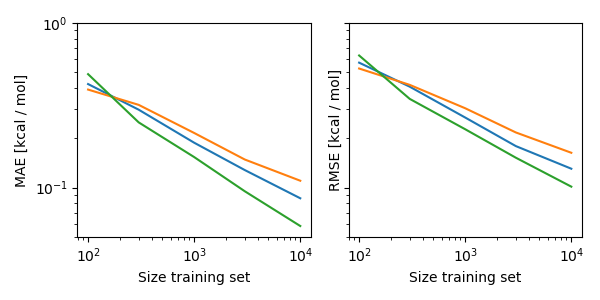

In [56]:
fig, axes = plt.subplots(ncols=2, figsize=[6,3], sharey=True)

ax = axes[0]

ax.plot(tsizes + [10000], lc_mae + [np.min(maes)], label='FCHL')
ax.plot(tsizes + [10000], lc_mae_mlkr + [np.min(maes_mlkr)], label='FHCL$_{MLKR}$')
ax.plot(tsizes + [10000], lc_mae_mlkrr + [np.min(maes_mlkrr)], label='FHCL$_{MLKRR}$')


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(0.05, 1)
ax.set_yticks([0.05, 0.1, 1])
ax.set_ylabel('MAE [kcal / mol]')
ax.set_xlabel('Size training set')

# ax.legend()

ax = axes[1]

ax.plot(tsizes + [10000], lc_rmse + [np.min(rmses)], label='FCHL')
ax.plot(tsizes + [10000], lc_rmse_mlkr + [np.min(rmses_mlkr)], label='FHCL$_{MLKR}$')
ax.plot(tsizes + [10000], lc_rmse_mlkrr + [np.min(rmses_mlkrr)], label='FHCL$_{MLKRR}$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('RMSE [kcal / mol]')
ax.set_xlabel('Size training set')
# ax.legend()

plt.tight_layout()
fig.savefig('learning_curves.pdf')

In [54]:
from sklearn.neighbors import KernelDensity

yy = predictions_test_original - target[indices_test]
yy = yy[:, np.newaxis]
kde = KernelDensity(kernel="gaussian", bandwidth=0.05).fit(yy)
xvals = np.linspace(-1, 1, 500)[:, np.newaxis]
log_dens_or = kde.score_samples(xvals)

yy = predictions_test_mlkrr - target[indices_test]
yy = yy[:, np.newaxis]
kde = KernelDensity(kernel="gaussian", bandwidth=0.05).fit(yy)
xvals = np.linspace(-1, 1, 500)[:, np.newaxis]
log_dens_mlkrr = kde.score_samples(xvals)

yy = predictions_test_mlkr - target[indices_test]
yy = yy[:, np.newaxis]
kde = KernelDensity(kernel="gaussian", bandwidth=0.05).fit(yy)
xvals = np.linspace(-1, 1, 500)[:, np.newaxis]
log_dens_mlkr = kde.score_samples(xvals)

<IPython.core.display.Javascript object>


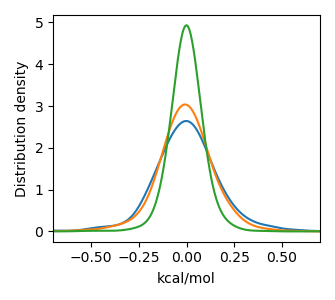

In [59]:
fig, ax = plt.subplots(figsize=[3.35,3])

ax.plot(xvals, np.exp(log_dens_or), label='FCHL \n MAE: 0.86')
ax.plot(xvals, np.exp(log_dens_mlkr), label='FHCL$_{MLKR}$ \n MAE: 0.92')
ax.plot(xvals, np.exp(log_dens_mlkrr), label='FHCL$_{MLKRR}$\n MAE: 0.60 ')
ax.set_xlim(-0.7, 0.7)
ax.set_xlabel('kcal/mol')
ax.set_ylabel('Distribution density')
# ax.legend(loc='upper left')
plt.tight_layout()
fig.savefig('error_dists.pdf')

In [60]:
pca_or = sk.decomposition.PCA(n_components=50)
pcas_or = pca_or.fit_transform(reps)

pca_mlkr = sk.decomposition.PCA(n_components=50)
pcas_mlkr = pca_or.fit_transform(reps_mlkr)

pca_mlkrr = sk.decomposition.PCA(n_components=50)
pcas_mlkrr = pca_or.fit_transform(reps_mlkrr)

In [62]:
import sklearn.manifold

# tsne_or = sk.manifold.TSNE(n_jobs=-1, init='pca', learning_rate='auto')
# tsnes_or = tsne_or.fit_transform(pcas_or)

# tsne_mlkrr = sk.manifold.TSNE(n_jobs=-1, init='pca', learning_rate='auto')
# tsnes_mlkrr = tsne_mlkrr.fit_transform(pcas_mlkrr)

# tsne_mlkr = sk.manifold.TSNE(n_jobs=-1, init='pca', learning_rate='auto')
# tsnes_mlkr = tsne_mlkr.fit_transform(pcas_mlkr)

In [63]:
tsne_or, tsnes_or = np.load('./tsne_fchl.npy', allow_pickle=True)
tsne_mlkrr, tsnes_mlkrr = np.load('./tsne_fchl_mlkrr.npy', allow_pickle=True)
tsne_mlkr, tsnes_mlkr = np.load('./tsne_fchl_mlkr.npy', allow_pickle=True)

<IPython.core.display.Javascript object>


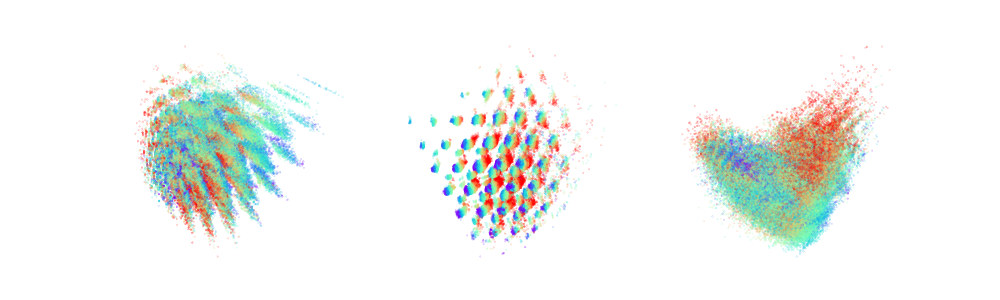

In [65]:
vvv = 2

ccc = target
fig, axes = plt.subplots(ncols=3, figsize=[10,3])

ax = axes[0]
ax.scatter(pcas_or[:,0], pcas_or[:,1], c=ccc, cmap='rainbow', s=0.01, vmin=-vvv, vmax=vvv)
ax.axis('off')

ax = axes[1]
cax = ax.scatter(pcas_mlkr[:,0], pcas_mlkr[:,1], c=ccc, cmap='rainbow', s=0.01, vmin=-vvv, vmax=vvv)
ax.axis('off')

ax = axes[2]
cax = ax.scatter(pcas_mlkrr[:,0], pcas_mlkrr[:,1], c=ccc, cmap='rainbow', s=0.01, vmin=-vvv, vmax=vvv)
ax.axis('off')
# cbar = fig.colorbar(cax)
# cbar.set_label('kcal / mol')
plt.savefig('./pcas.png', dpi=300)

<IPython.core.display.Javascript object>


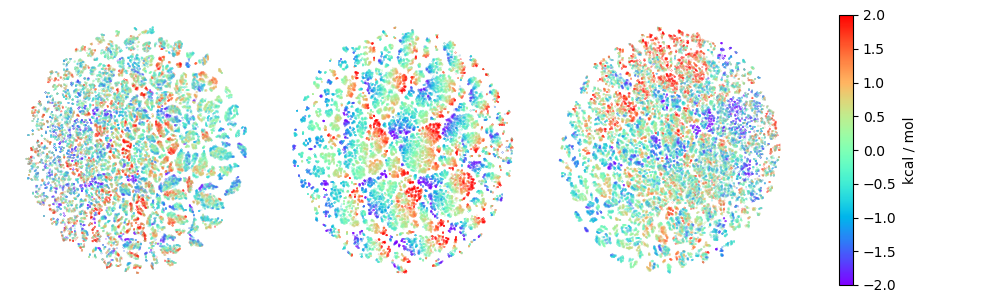

In [64]:
vvv = 2

ccc = target
fig, axes = plt.subplots(ncols=3, figsize=[10,3])

ax = axes[0]
ax.scatter(tsnes_or[:,0], tsnes_or[:,1], c=ccc, cmap='rainbow', s=0.001, vmin=-vvv, vmax=vvv)
ax.axis('off')

ax = axes[1]
cax = ax.scatter(tsnes_mlkr[:,0], tsnes_mlkr[:,1], c=ccc, cmap='rainbow', s=0.001, vmin=-vvv, vmax=vvv)
ax.axis('off')

ax = axes[2]
cax = ax.scatter(tsnes_mlkrr[:,0], tsnes_mlkrr[:,1], c=ccc, cmap='rainbow', s=0.001, vmin=-vvv, vmax=vvv)
ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0)

cbar = fig.colorbar(cax, ax=axes.ravel().tolist())
cbar.set_label('kcal / mol')
fig.savefig('tsnes.png', dpi=300)

In [66]:
rep_vars = reps.var(axis=0)
rep_vars_mlkr = reps_mlkr.var(axis=0)
rep_vars_mlkrr = reps_mlkrr.var(axis=0)

<IPython.core.display.Javascript object>


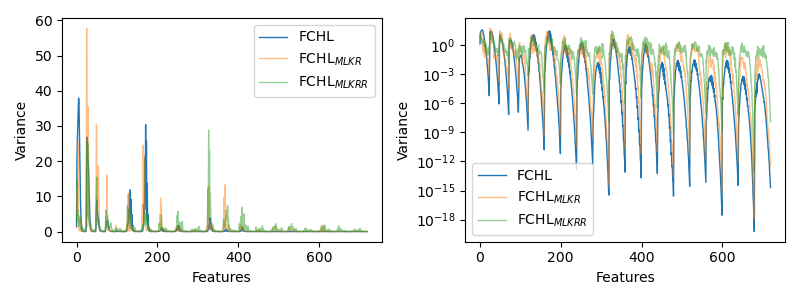

In [67]:
fig, axes = plt.subplots(figsize=[8,3], ncols=2)

ax = axes[0]
ax.plot(rep_vars / np.mean(rep_vars), label='FCHL', linewidth=1)
ax.plot(rep_vars_mlkr / np.mean(rep_vars_mlkr), label='FCHL$_{MLKR}$', alpha=0.5, linewidth=1)
ax.plot(rep_vars_mlkrr / np.mean(rep_vars_mlkrr), label='FCHL$_{MLKRR}$', alpha=0.5, linewidth=1)
# ax.set_ylim(0, 10)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.legend()

ax = axes[1]
ax.plot(rep_vars / np.mean(rep_vars), label='FCHL', linewidth=1)
ax.plot(rep_vars_mlkr / np.mean(rep_vars_mlkr), label='FCHL$_{MLKR}$', alpha=0.5, linewidth=1)
ax.plot(rep_vars_mlkrr / np.mean(rep_vars_mlkrr), label='FCHL$_{MLKRR}$', alpha=0.5, linewidth=1)
# ax.set_ylim(0, 10)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.legend()
ax.set_yscale('log')

# ax.set_yscale('log')
plt.tight_layout()
plt.show()
fig.savefig('variances_all.pdf')

<IPython.core.display.Javascript object>


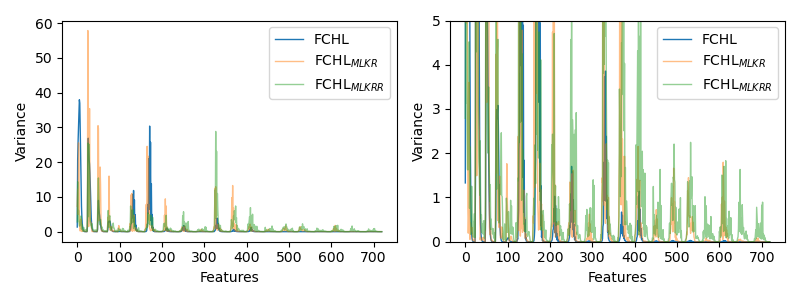

In [68]:
fig, axes = plt.subplots(figsize=[8,3], ncols=2)

ax = axes[0]
ax.plot(rep_vars / np.mean(rep_vars), label='FCHL', linewidth=1)
ax.plot(rep_vars_mlkr / np.mean(rep_vars_mlkr), label='FCHL$_{MLKR}$', alpha=0.5, linewidth=1)
ax.plot(rep_vars_mlkrr / np.mean(rep_vars_mlkrr), label='FCHL$_{MLKRR}$', alpha=0.5, linewidth=1)
# ax.set_ylim(0, 10)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.legend()

ax = axes[1]
ax.plot(rep_vars / np.mean(rep_vars), label='FCHL', linewidth=1)
ax.plot(rep_vars_mlkr / np.mean(rep_vars_mlkr), label='FCHL$_{MLKR}$', alpha=0.5, linewidth=1)
ax.plot(rep_vars_mlkrr / np.mean(rep_vars_mlkrr), label='FCHL$_{MLKRR}$', alpha=0.5, linewidth=1)
# ax.set_ylim(0, 10)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.legend()
ax.set_ylim(0,5)
# ax.set_yscale('log')
plt.tight_layout()
plt.show()
# fig.savefig('variances_all.pdf')

<IPython.core.display.Javascript object>


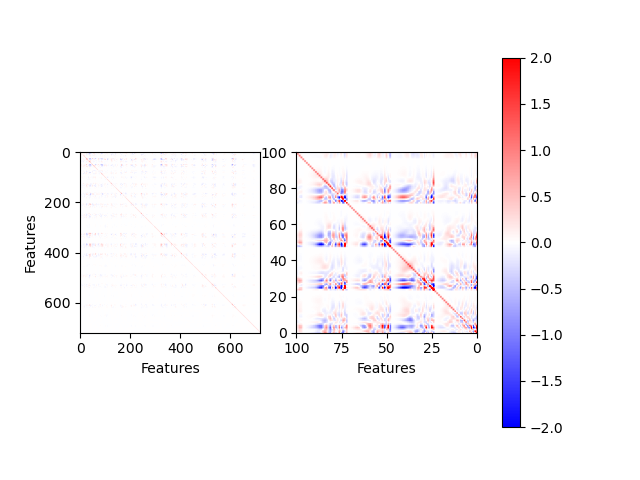

In [69]:
fig, axes = plt.subplots(ncols=2)

vv = 2
ax = axes[0]
ax.imshow(mlkr_model.A, cmap='bwr', vmax=vv, vmin=-vv)

ax.set_xlabel('Features')
ax.set_ylabel('Features')

ax = axes[1]
cax = ax.imshow(mlkr_model.A, cmap='bwr', vmax=vv, vmin=-vv)
ax.set_xlim(100, 0)
ax.set_ylim(0, 100)
ax.set_xlabel('Features')

plt.show()

fig.colorbar(cax, ax=axes.ravel().tolist())
plt.savefig('mat_a_mlkr.pdf')

<IPython.core.display.Javascript object>


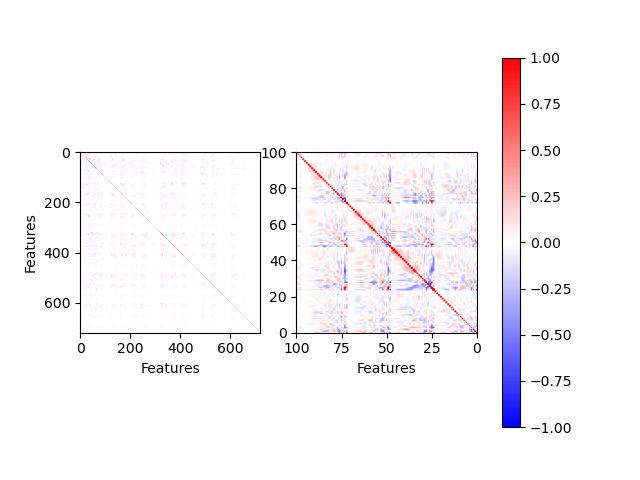

In [70]:
fig, axes = plt.subplots(ncols=2)

vv = 1
ax = axes[0]
ax.imshow(mlkrr_model.A, cmap='bwr', vmax=vv, vmin=-vv)

ax.set_xlabel('Features')
ax.set_ylabel('Features')

ax = axes[1]
cax = ax.imshow(mlkrr_model.A, cmap='bwr', vmax=vv, vmin=-vv)
ax.set_xlim(100, 0)
ax.set_ylim(0, 100)
ax.set_xlabel('Features')

plt.show()

fig.colorbar(cax, ax=axes.ravel().tolist())
plt.savefig('mat_a_mlkrr.pdf')